# Problem Set 3
### Tyler Amos, MACSS 30100
24 January 2018

In [115]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy import optimize as opt
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
%matplotlib inline
income_data = pd.read_csv("incomes.txt", header = None, names = ['amount'])
incomes = income_data.amount
sickness = pd.read_csv("sick.txt")

# a.)

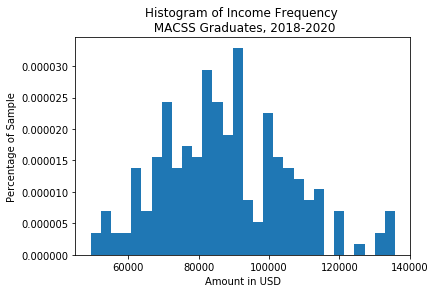

In [116]:
# histogram
plt.hist(incomes, normed = True, bins = 30)
plt.xlabel("Amount in USD")
plt.ylabel("Percentage of Sample")
plt.title("Histogram of Income Frequency \n MACSS Graduates, 2018-2020")
plt.show()

# b.)

In [117]:
def lognorm_pdf(mu, sigma, xvals):
    '''This is the lognormal distribution. 
    In: mu (float), sigma (float), xvals (array of floats), Out: an array of floats'''
    return ((1/(xvals * sigma * np.sqrt(2 * np.pi))) * \
            np.exp( - ((np.log(xvals) - mu)**2 / (2 * (sigma**2)))))

def model_moments(mu, std, xvals):
    '''Find the mean and standard deviation of the lognormal model.
    In: mu (float), std (sigma, float), xvals (an array of floats)
    Out: model_mean (float), model_std (float)'''
    model_mean = np.mean(lognorm_pdf(mu, std, xvals))
    model_std = np.std(lognorm_pdf(mu, std, xvals))
    return model_mean, model_std

def errors_vec(mu, std, xvals):
    '''Find the difference between the model and data mean, standard deviation.
    In: mu (float), std (sigma, float), xvals (an array of floats)
    Out: the difference between the model and data, as a percent (array of floats)
    '''
    # subtract the model moments from the data
    model_mean, model_std = model_moments(mu, std, xvals)
    data_mean, data_std = data_moments(xvals)
    model = np.array([model_mean, model_std])
    data = np.array([data_mean, data_std])
    # perform the subtraction and express it as a proportion of the data
    diff = model - data / data
    return diff

def data_moments(x):
    '''In: x (array), 
    Out: the average and standard deviation (floats)
    '''
    av =  np.mean(x)
    std = np.std(x)
    return av, std

def criterion(params, *args):
    '''In: My guesses for mean (float), standard deviation; xvals (data), and weighting matrix (W)
    Out: criterion value by which we optimize'''
    mu, std = params
    xvals, W = args
    errors = errors_vec(mu, std, xvals)
    # matrix multiply the transpose of the errors, the weighting and the errors once again
    return np.dot(np.dot(errors.T, W), errors)

mu_GMM1= 11.3556556664 sig_GMM1= 0.21717247043


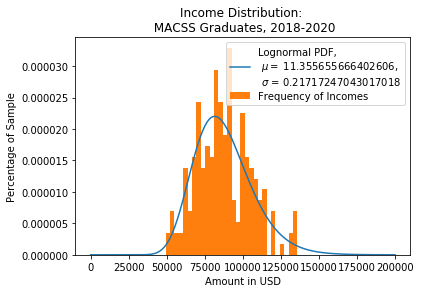

Criterion function value: 2.0


In [118]:
mu_init = np.mean(np.log(incomes[0:50]))
std_init = np.std(np.log(incomes[0:50]))
params_init = np.array([mu_init, std_init])
weight = np.eye(2)
incomes_s = np.log(incomes)
gmm_args = (incomes_s, weight)
results = opt.minimize(criterion, params_init, args=(gmm_args), method = 'L-BFGS-B', bounds=((0.001, None), (0.001, None)))
mu_GMM1, std_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, 'sig_GMM1=', std_GMM1)

# plot
x_axis = np.linspace(.01, 200000, 500)
plt.plot(x_axis, lognorm_pdf(mu_GMM1, std_GMM1, x_axis), label = "Lognormal PDF, \n $\mu =$ {},\n $\sigma $ = {}".format(mu_GMM1, std_GMM1))
plt.hist(incomes, bins = 30, normed = True, label = "Frequency of Incomes")
plt.xlabel("Amount in USD")
plt.ylabel("Percentage of Sample")
plt.title("Income Distribution: \n MACSS Graduates, 2018-2020")
plt.legend()
plt.show()

print("Criterion function value:", results.fun)

The estimated value of the criterion function with the estimated parameters is $\approx 1.99999$

In [119]:
mean, std = data_moments(incomes)
print('Data (USD): \nMean: {}, Standard Deviation: {}\n'.format(mean, std))
print('Model (USD): \nMean:{}, Standard Deviation: {}'.format(np.exp(mu_GMM1), (std_GMM1*np.exp(mu_GMM1))))

Data (USD): 
Mean: 87588.93076851233, Standard Deviation: 18035.906827092327

Model (USD): 
Mean:85447.34919915737, Standard Deviation: 18556.81191729043


We can see that the data and model moments are quite close, within a few thousand dollars for the mean, and a few hundred dollars for the standard deviation. 

# c.)

      fun: 200.00431863531617
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 11.35040654,   0.20817733])

Data (USD): 
Mean: 87588.93076851233, Standard Deviation: 18035.906827092327

Model (USD): 
Mean:85000.0, Standard Deviation: 17695.072775319833
Criterion function value: 200.004318635


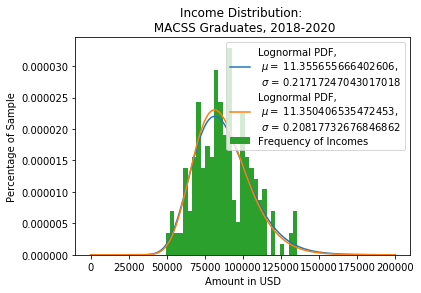

In [120]:
# Create a weighting matrix
errors_vector = errors_vec(mu_GMM1, std_GMM1, incomes)
errors_vector = errors_vector.reshape(2,1)
VCV2 = np.dot(errors_vector, errors_vector.T) / incomes.shape[0]
W_hat2 = lin.pinv(VCV2)

# Apply the optimization with some guesses
mu_init = np.mean(np.log(85000))
std_init = np.std(np.log(incomes))
params_init = np.array([mu_init, std_init])
gmm_args = (incomes_s, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, std_GMM2 = results.x
print(results)

# present results
mean, std = data_moments(incomes)
print('\nData (USD): \nMean: {}, Standard Deviation: {}\n'.format(mean, std))
print('Model (USD): \nMean:{}, Standard Deviation: {}'.format(np.exp(mu_GMM2), (std_GMM2*np.exp(mu_GMM2))))
print("Criterion function value:", results.fun)

# plot results
x_axis = np.linspace(.01, 200000, 500)
plt.plot(x_axis, lognorm_pdf(mu_GMM1, std_GMM1, x_axis), label = "Lognormal PDF, \n $\mu =$ {},\n $\sigma $ = {}".format(mu_GMM1, std_GMM1))
plt.plot(x_axis, lognorm_pdf(mu_GMM2, std_GMM2, x_axis), label = "Lognormal PDF, \n $\mu =$ {},\n $\sigma $ = {}".format(mu_GMM2, std_GMM2))
plt.hist(incomes, bins = 30, normed = True, label = "Frequency of Incomes")
plt.xlabel("Amount in USD")
plt.ylabel("Percentage of Sample")
plt.title("Income Distribution: \n MACSS Graduates, 2018-2020")
plt.legend()
plt.show()

We can see that once again the moments are quite close, within a few thousand dollars for the mean and the standard deviation.

# d.)

In [121]:
def data_moments(data):
    '''Collect the data moments:
    % below 75k
    % between 75k and 100k
    % above 100k
    In: data (array), Out: the data moments, as above'''
    lt_75k = len(data[data < 75000])/len(data)
    bt_75k_100k = len(data[data < 100000])/len(data) - lt_75k
    gt_100k = 1 - (lt_75k + bt_75k_100k)
    return lt_75k, bt_75k_100k, gt_100k

def model_moment(mu, std, xvals, cutoff):
    '''This is a helper function to integrate under a lognormal function, as defined by
    the mu, standard deviation, and the cutoff value (either 75k, 100k).
    In: mu (float), std (sigma, float), xvals (an array of floats), cutoff (the upper level of the integral)
    Out: model_moment, the value of the integral from zero to the cutoff'''
    func = lambda xvals: lognorm_pdf(mu, std, xvals)
    # One can't earn more than zero
    return intgr.quad(func, 0.00001, cutoff)

def errors_vec(mu, std, xvals):
    '''Find the difference between the model and data moments.
    In: mu (float), std (sigma, float), xvals (an array of floats)
    Out: the difference between the model and data, as a percent (array of floats)
    '''
    # Get the model moments, deriving as necessary from each other
    lt_75k_mod = model_moment(mu, std, xvals, 75000)[0]
    bt_75k_100k_mod  = model_moment(mu, std, xvals, 100000)[0] - lt_75k_mod
    gt_100k_mod  = 1 - model_moment(mu, std, xvals, 100000)[0]
    lt_75k, bt_75k_100k, gt_100k = data_moments(xvals)
    model = np.array([lt_75k_mod, bt_75k_100k_mod, gt_100k_mod])
    data = np.array([lt_75k, bt_75k_100k, gt_100k])
    # perform the subtraction and express it as a proportion of the data
    return (model - data)/data

def criterion(params, *args):
    '''In: My guesses for mean (float), standard deviation; xvals (data), and weighting matrix (W)
    Out: criterion value by which we optimize'''
    mu, sigma = params
    xvals, W = args
    err = errors_vec(mu, std, xvals)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

mu_GMM1_d = 11.3556556664  sig_GMM1_d = 0.21717247043
      fun: 10.085625776552941
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 11.35565567,   0.21717247])

 Data Moments (USD), 
  x < 75,000:  0.265, 
 75,000 < x > 100,000:  0.475, 
 x > 100,000:  0.26

 Model Moments (USD), 
  x < 75,000:  0.2740862153924389, 
 75,000 < x > 100,000:  0.49143311270970996, 
 x > 100,000:  0.23448067189785116

 Criterion function value: 10.0856257766


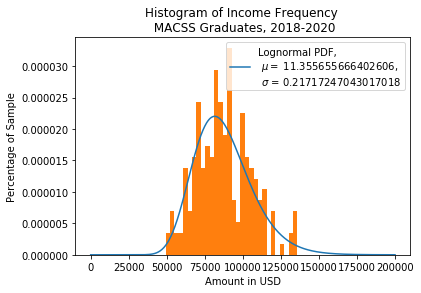

In [123]:
# Use a sample to set the initial values
mu_init = np.mean(np.log(incomes[0:50]))
std_init = np.std(np.log(incomes[0:50]))
params_init = np.array([mu_init, std_init])

# Let the weighting be the identity matrix
W_hat = np.eye(3)
gmm_args = (incomes, W_hat)
# Optimize
results_d = opt.minimize(criterion, params_init, method='L-BFGS-B', args=(gmm_args), bounds=((None, None), (None, None)))
mu_GMM1_d, std_GMM1_d = results_d.x
print('mu_GMM1_d =', mu_GMM1_d, ' sig_GMM1_d =', std_GMM1_d)
print(results_d)

# Get the moments and present them
low, med, high = data_moments(incomes)
print('\n Data Moments (USD), \n  x < 75,000:  {}, \n 75,000 < x > 100,000:  {}, \n x > 100,000:  {}'.format(low, med, high))
low  = model_moment(mu_GMM1_d, std_GMM1_d, incomes, 75000)[0]
med  = model_moment(mu_GMM1_d, std_GMM1_d, incomes, 100000)[0] - low
high = 1 - model_moment(mu_GMM1_d, std_GMM1_d, incomes, 100000)[0]
print('\n Model Moments (USD), \n  x < 75,000:  {}, \n 75,000 < x > 100,000:  {}, \n x > 100,000:  {}'.format(low, med, high))
print("\n Criterion function value:", results_d.fun)

# Plot them
x_axis = np.linspace(.01, 200000, 500)
plt.plot(x_axis, lognorm_pdf(mu_GMM1_d, std_GMM1_d, x_axis), label = "Lognormal PDF, \n $\mu =$ {},\n $\sigma $ = {}".format(mu_GMM1_d, std_GMM1_d))
plt.hist(incomes, normed = True, bins = 30)
plt.legend()
plt.xlabel("Amount in USD")
plt.ylabel("Percentage of Sample")
plt.title("Histogram of Income Frequency \n MACSS Graduates, 2018-2020")
plt.show()


# e.)

mu_GMM2_d = 11.3556556664  sig_GMM2_d = 0.21717247043
      fun: 168006.585791266
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 11.35565567,   0.21717247])
Data Moments (USD), 
  x < 75,000:  0.265, 
 75,000 < x > 100,000:  0.475, 
 x > 100,000:  0.26

 Model Moments (USD), 
  x < 75,000:  0.2740862153924389, 
 75,000 < x > 100,000:  0.49143311270970996, 
 x > 100,000:  0.23448067189785116

 Criterion function value: 12.0317584588


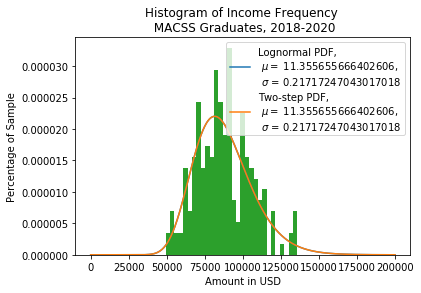

In [124]:
# Now doing two step

# Create the weighting matrix
errors_vector = errors_vec(mu_GMM1_d, std_GMM1_d, incomes)
errors_vector = errors_vector.reshape(3,1)
VCV2 = np.dot(errors_vector, errors_vector.T) / incomes.shape[0]
W_hat2_d = lin.pinv(VCV2)

# Use a sample to set the initial values
mu_init = np.mean(np.log(incomes[0:50]))
std_init = np.std(np.log(incomes[0:50]))
params_init = np.array([mu_init, std_init])
gmm_args = (incomes, W_hat2_d)
results2_d = opt.minimize(criterion, params_init, method='L-BFGS-B', args=(gmm_args), bounds=((None, None), (1e-10, None)))
mu_GMM2_d, std_GMM2_d = results2_d.x
print('mu_GMM2_d =', mu_GMM2_d, ' sig_GMM2_d =', std_GMM2_d)
print(results2_d)

# print out results and compare
low, med, high = data_moments(incomes)
print('Data Moments (USD), \n  x < 75,000:  {}, \n 75,000 < x > 100,000:  {}, \n x > 100,000:  {}'.format(low, med, high))
low  = model_moment(mu_GMM2_d, std_GMM2_d, incomes, 75000)[0]
med  = model_moment(mu_GMM2_d, std_GMM2_d, incomes, 100000)[0] - low
high = 1 - model_moment(mu_GMM2_d, std_GMM2_d, incomes, 100000)[0]
print('\n Model Moments (USD), \n  x < 75,000:  {}, \n 75,000 < x > 100,000:  {}, \n x > 100,000:  {}'.format(low, med, high))
print("\n Criterion function value:", np.log(results2_d.fun)) # log to make it comparable  to the previous value


# Plot the results
x_axis = np.linspace(.01, 200000, 500)
plt.plot(x_axis, lognorm_pdf(mu_GMM1_d, std_GMM1_d, x_axis), label = "Lognormal PDF, \n $\mu =$ {},\n $\sigma $ = {}".format(mu_GMM1_d, std_GMM1_d))
plt.plot(x_axis, lognorm_pdf(mu_GMM2_d, std_GMM2_d, x_axis), label = "Two-step PDF, \n $\mu =$ {},\n $\sigma $ = {}".format(mu_GMM1_d, std_GMM1_d))
plt.hist(incomes, normed = True, bins = 30)
plt.legend()
plt.xlabel("Amount in USD")
plt.ylabel("Percentage of Sample")
plt.title("Histogram of Income Frequency \n MACSS Graduates, 2018-2020")
plt.show()


# f.)

All estimations are essentially equivalent, any variation is minor relative to the overall variation in the dataset, as we can see from the plot below. While all of the approaches offer essentially the same results, the simplicity of (b), that is just using $\sigma$ and $\mu$, not specified quantiles, and not employing the two-step procedure, has the added benefit of simplicity. As the goal of modelling is to approximate (social) reality with the most simple model possible (but no simpler), this is a significant advantage. Therefore, I would select (b) as the best fit for the data. 

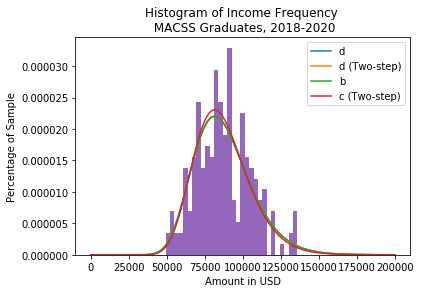

In [125]:
# plot all the models and a histogram
x_axis = np.linspace(.01, 200000, 500)
plt.plot(x_axis, lognorm_pdf(mu_GMM1_d, std_GMM1_d, x_axis), label = "d")
plt.plot(x_axis, lognorm_pdf(mu_GMM2_d, std_GMM2_d, x_axis), label = "d (Two-step)")
plt.plot(x_axis, lognorm_pdf(mu_GMM1, std_GMM1, x_axis), label = "b")
plt.plot(x_axis, lognorm_pdf(mu_GMM2, std_GMM2, x_axis), label = "c (Two-step)")
plt.hist(incomes, normed = True, bins = 30)
plt.legend()
plt.xlabel("Amount in USD")
plt.ylabel("Percentage of Sample")
plt.title("Histogram of Income Frequency \n MACSS Graduates, 2018-2020")
plt.show()

# 2

# a.)

In [126]:
def errors_vec(b_0, b_1, b_2, b_3, data):
    '''Find the difference between predicted and actual data points.
    In: beta values from 0 - 3, data (pandas data frame)
    Out: the difference between the model and data, as a percent (array of floats)
    '''
    data_mom = data.sick
    model_mom = b_0 + b_1 * data.age + b_2 * data.children + b_3 * data.avgtemp_winter
    return data_mom - model_mom
    
def criterion(params, *args):
    '''Criterion function for optimizer. 
    In: params: beta values from 0-3, args: data (pandas data frame)
    Out: criterion value by which we judge the model parameters'''
    b_0, b_1, b_2, b_3 = params
    xvals = args[0]
    # A 200 x 200 identity matrix
    W = np.eye(200)
    err = errors_vec(b_0, b_1, b_2, b_3, xvals)
    # Make sure it's a matrix
    err = err.values.reshape(200,1)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [127]:
args = sickness
# Initial guesses about the coefficients
params = np.array([0, .4, .2, 0.3])
linregress_results = opt.minimize(criterion, params, method='L-BFGS-B', args=(args), bounds=((None, None),\
                                                                                     (None, None), \
                                                                                     (None, None), \
                                                                                     (None, None)))
print("Coefficient Estimates:")
print(linregress_results.x)
print("\nGMM Criterion Function Value: \n", linregress_results.fun )

Coefficient Estimates:
[ 0.25164478  0.01293345  0.40050113 -0.0099917 ]

GMM Criterion Function Value: 
 [[ 0.00182129]]


Using the initial guesses above, the model can be estimated at (approximately): 

$ sick_i \approx 0.25164478 + 0.01293345(age_i) + 0.40050113(children_i)  -0.0099917(temperature_i) + \epsilon$ 

Where $\epsilon $ ~ $N(\sigma, \mu)$

This makes intuitive sense and passes the 'smell test':

_Age_: The older children are, the more likely they are to be in school and therefore exposed to more pathogens.

_Children_: On a related note, more children present more opportunities to collect pathogens. 

_Temperature_: Colder temperatures have a long-running association with illness which is established in common sense and medical literature. Individuals are more likely to stay indoors when the weather is cold, leading to greater exposure to transmission from others. 